## PyG package test
https://www.pyg.org/

In [1]:
# pytorch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 3.1 MB/s 
     |████████████████████████████████| 3.5 MB 3.0 MB/s 
     |████████████████████████████████| 370 kB 13.8 MB/s 
     |████████████████████████████████| 482 kB 54.2 MB/s 
     |████████████████████████████████| 41 kB 463 kB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla T4


In [3]:
filepath='/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs_new1/'
x=np.load(filepath+'pickle/ac118_p10_x_nominal.npy').transpose(2,0,1)
y=np.load(filepath+'pickle/ac118_p10_y_nominal.npy').transpose()
w=np.load(filepath+'pickle/ac118_p10_w_nominal.npy')
params=np.load(filepath+'pickle/ac118_p10_sys_nominal.npy')
num_bus=y.shape[-1]
num_feat=x.shape[-1]
num_line=params.shape[0]
num_load=int(params[2,0].copy())
num_sample=x.shape[0]
line_bus=params[:,1:3].copy()
print(np.max(x),np.min(x),np.max(y),np.min(y))
print('Data size:',x.shape)
print('Label size:',y.shape)

from torch_geometric.data import Data
def data_helper(w,x,y=None):
  # construct edge index from w
  edge_index=[[],[]]
  for node in w:
    source=[]
    target=-1
    for idx,ele in enumerate(node):
      if ele>0: target=idx
      elif ele<0: source.append(idx)
    for ele in source:
      edge_index[0].append(target)
      edge_index[1].append(ele)
  edge_index=torch.tensor(edge_index,dtype=torch.long)
  data=[]
  for idx,ele in enumerate(x):
    if y is not None:
      data.append(Data(
          x=torch.tensor(ele,dtype=torch.float),
          edge_index=edge_index,
          y=torch.tensor([[temp] for temp in y[idx]],dtype=torch.float)
      ))
    else:
      data.append(Data(
          x=torch.tensor(ele,dtype=torch.float),
          edge_index=edge_index,
          # y=torch.tensor([[temp] for temp in y[idx]],dtype=torch.float)
      ))
  return data

data=data_helper(w.copy(),x.copy(),y.copy())
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
train,test=train_test_split(data)
trainset=DataLoader(train,batch_size=128,shuffle=True)
testset=DataLoader(test,batch_size=128,shuffle=True)

# loss func
loss_func=nn.MSELoss()
def my_loss_func(pred,label):
  mse=loss_func(pred,label)
  lmda1=torch.tensor(1).to(device) #L_2
  lmda2=torch.tensor(0.01).to(device) #L_inf
  linf=(pred-label).norm(p=float('inf'))
  return lmda1*mse+lmda2*linf

1418.4 0.0 55.948 10.096
Data size: (7000, 118, 3)
Label size: (7000, 118)


In [4]:
from torch_geometric.nn import GCNConv
class myGCN(nn.Module):
  def __init__(self,sizes):
    super().__init__()
    self.conv1=GCNConv(num_feat,sizes[0])
    self.conv2=GCNConv(sizes[0],sizes[1])
    self.conv3=GCNConv(sizes[1],sizes[2])
    self.conv4=GCNConv(sizes[2],sizes[3])
    self.conv5=GCNConv(sizes[3],sizes[4])
    self.conv6=GCNConv(sizes[-1],1)
    self.lin=nn.Linear(num_bus,num_bus)
  def forward(self,batch):
    x=self.conv1(batch.x,batch.edge_index)
    x=self.conv2(x,batch.edge_index)
    x=F.relu(x)
    x=F.dropout(x)
    x=self.conv3(x,batch.edge_index)
    x=self.conv4(x,batch.edge_index)
    x=F.relu(x)
    x=F.dropout(x)
    x=self.conv5(x,batch.edge_index)
    x=self.conv6(x,batch.edge_index)
    x=x.reshape((-1,num_bus))
    x=self.lin(x)
    x=x.reshape((-1,))
    return x
net=myGCN([10,15,15,10,10]).to(device)
optimizer=torch.optim.Adam(net.parameters(),weight_decay=0.99)
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

myGCN(
  (conv1): GCNConv(3, 10)
  (conv2): GCNConv(10, 15)
  (conv3): GCNConv(15, 15)
  (conv4): GCNConv(15, 10)
  (conv5): GCNConv(10, 10)
  (conv6): GCNConv(10, 1)
  (lin): Linear(in_features=118, out_features=118, bias=True)
)
number of params: 14768


In [5]:
## Training
t0=time.time()
max_epochs=200
eval_epoch=5

# earlystopping
tolerance=10
min_delta=1e-2
previous=0
for epoch in range(max_epochs):
  # training
  train_loss=0.0
  for batch in trainset:
    optimizer.zero_grad() # clear the past gradient
    batch=batch.to(device)
    logits=net(batch)
    loss=my_loss_func(logits,batch.y.squeeze())
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(trainset.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(trainset.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for batch in testset:
      batch=batch.to(device)
      logits=net(batch)
      loss=my_loss_func(logits,batch.y.squeeze())
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(testset.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch,eval_loss/len(testset.dataset)])
    net.train()
t1=time.time()
print("Training time: %.4fs"%(t1-t0))

Epoch 0 | Training loss: 2.0900
Epoch 1 | Training loss: 0.2118
Epoch 2 | Training loss: 0.1839
Epoch 3 | Training loss: 0.1619
Epoch 4 | Training loss: 0.1581
Epoch 4 | Eval loss: 0.1561
Epoch 5 | Training loss: 0.1514
Epoch 6 | Training loss: 0.1439
Epoch 7 | Training loss: 0.1389
Epoch 8 | Training loss: 0.1318
Epoch 9 | Training loss: 0.1312
Epoch 9 | Eval loss: 0.1276
Epoch 10 | Training loss: 0.1242
Epoch 11 | Training loss: 0.1196
Epoch 12 | Training loss: 0.1214
Epoch 13 | Training loss: 0.1216
Epoch 14 | Training loss: 0.1184
Epoch 14 | Eval loss: 0.1115
Epoch 15 | Training loss: 0.1148
Epoch 16 | Training loss: 0.1136
Epoch 17 | Training loss: 0.1082
Epoch 18 | Training loss: 0.1145
Epoch 19 | Training loss: 0.1020
Epoch 19 | Eval loss: 0.1011
Epoch 20 | Training loss: 0.1078
Epoch 21 | Training loss: 0.1051
Epoch 22 | Training loss: 0.1002
Epoch 23 | Training loss: 0.1007
Epoch 24 | Training loss: 0.1018
Epoch 24 | Eval loss: 0.1149
Epoch 25 | Training loss: 0.1007
Epoch 26 

13


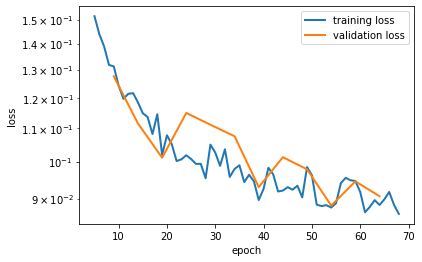

./drive/My Drive/gnn/geometric/118ac_topoadapt.pickle


In [6]:
import matplotlib.pyplot as plt
val_len=len(loss_val)
print(val_len)
val_plt=np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i]=loss_val[i][0]
  val_plt[1,i]=loss_val[i][1]
plt.figure()
plot_idx = np.arange(np.size(loss_optm))
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# Save the pre-trained model
path='./drive/My Drive/gnn/geometric/118ac_topoadapt.pickle'
torch.save(net.state_dict(),path)
print(path)

(1750,) (1750,)
L2 mean: 0.12940433748492172 L_inf mean: 0.2382286301595824


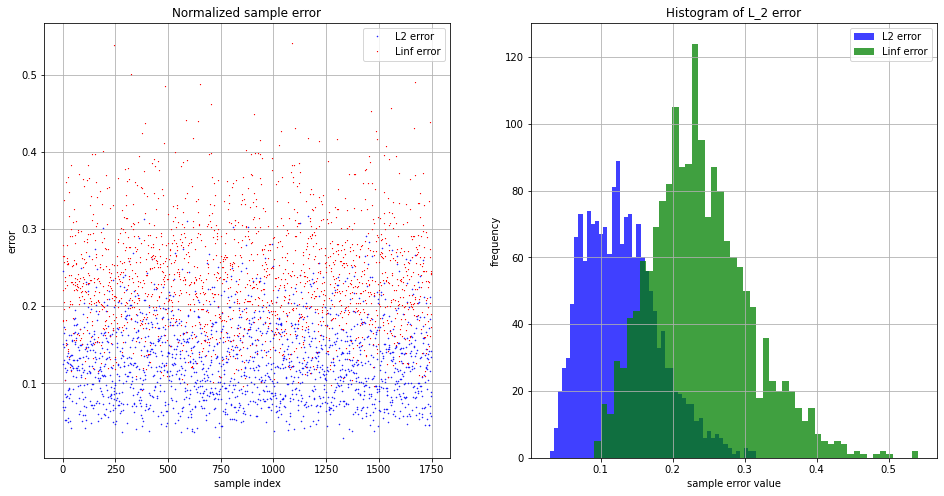

In [7]:
net.eval()
y_pred=[]
y_label=[]
for batch in testset:
  batch=batch.to(device)
  logits=net(batch)
  y_pred.extend(logits.squeeze().cpu().detach().numpy())
  y_label.extend(batch.y.squeeze().cpu().detach().numpy())
y_pred=np.array(y_pred)
y_label=np.array(y_label)

n_test=len(test)
err_L2=np.zeros(n_test)
err_Linf=np.zeros(n_test)
for idx in range(0,len(y_label),num_bus):
  err_L2[idx//num_bus]=np.linalg.norm(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus])/np.linalg.norm(y_label[idx:idx+num_bus])
  err_Linf[idx//num_bus]=np.max(np.abs(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus]))/np.max(np.abs(y_label[idx:idx+num_bus]))
print(err_L2.shape,err_Linf.shape)
err_L2_mean=np.mean(err_L2)
err_Linf_mean=np.mean(err_Linf)
print('L2 mean:',err_L2_mean,'L_inf mean:',err_Linf_mean)
nominal=err_L2.copy()

fig2=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(err_L2,'bo',markersize=0.5,label='L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label='Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1,2,2)
plt.hist(err_L2,bins=50,facecolor='b',alpha=0.75,label='L2 error')
plt.hist(err_Linf,bins=50,facecolor='g',alpha=0.75,label='Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
plt.grid(True)
plt.show()

1750 L2 mean: 0.12940433748492172 1750 L_inf mean: 0.2382286301595824


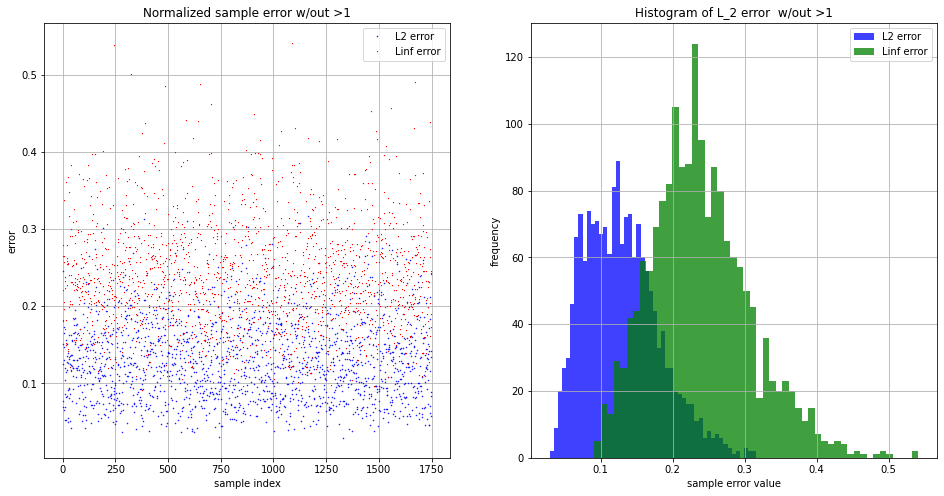

In [8]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [13]:
# validate on topology changes
filepath='/content/drive/My Drive/gnn/data/data_118ac_topo_3inputs_new1/'
filename=filepath+'ieee118ac_topo_topo_effective_index.txt'
effective_index=pd.read_table(filename,sep=',',header=None).to_numpy()[:,1:].transpose()
y_pert=np.load(filepath+'pickle/ac118_p10_y_pert.npy').transpose(0,2,1)
effective_samples=y_pert.shape[1]
num_system=effective_index.shape[0]

# pert systems
x_pert=[]
for system in range(num_system):
  x_system=np.zeros((effective_samples,num_bus,3))
  idx=0
  for sample in range(effective_index.shape[1]):
    if effective_index[system][sample]>0:
      x_system[idx]=x[sample].copy()
      idx+=1
      if idx==effective_samples: break
  x_pert.append(x_system)

In [14]:
def graph_laplacian(line,num_line,num_bus):
	incidence=np.zeros((num_line,num_bus))
	for i in range(num_line):
		incidence[i,int(line[i,0])-1]=incidence[i,int(line[i,0])-1]+1 # source
		incidence[i,int(line[i,1])-1]=incidence[i,int(line[i,1])-1]-1 # destination
	w=np.matmul(incidence.transpose(),incidence)
	return w

filename=filepath+'118ac_recorded_deletion_idx.txt'
del_idx=pd.read_table(filename,sep=',',header=None).to_numpy().transpose()
del_num=np.sum(del_idx,1)
net_pert=myGCN([10,15,15,10,10]).to(device)
path='./drive/My Drive/gnn/geometric/118ac_topoadapt.pickle'
net_pert.load_state_dict(torch.load(path))
net_pert.eval()

err_L2_total=[]
err_Linf_total=[]
for idx in range(num_system):
  line_bus1=line_bus.copy()
  for i in range(num_line,0,-1):
    if del_idx[idx,i-1]>0:
      line_bus1=np.delete(line_bus1,i-1,0)
  w_pert=graph_laplacian(line_bus1,num_line-del_num[idx],num_bus)
  w_pert=np.abs(w_pert)
  data_pert=data_helper(w_pert.copy(),x_pert[idx].copy(),y_pert[idx].copy())
  pert_set=DataLoader(data_pert,batch_size=512,shuffle=True)
  y_pred=[]
  for batch in pert_set:
    logits=net_pert(batch.to(device))
    y_pred.extend(logits.squeeze().cpu().detach().numpy())
  y_pred=np.array(y_pred)
  y_label=y_pert[idx].flatten()
  num_test=len(data_pert)
  err_L2=np.zeros(num_test)
  err_Linf=np.zeros(num_test)
  for sample in range(0,len(y_label),num_bus):
    err_L2[sample//num_bus]=np.linalg.norm(y_label[sample:sample+num_bus]-y_pred[sample:sample+num_bus])/np.linalg.norm(y_label[sample:sample+num_bus])
    err_Linf[sample//num_bus]=np.max(np.abs(y_label[sample:sample+num_bus]-y_pred[sample:sample+num_bus]))/np.max(np.abs(y_label[sample:sample+num_bus]))
  err_L2_total.append(err_L2)
  err_Linf_total.append(err_Linf)

L2 mean: 0.14826284252443658 L2 variance: 0.0050961718732002795 L_inf mean: 0.23325343112892033
L2 mean: 0.14656368612111378 L2 variance: 0.0036501463477493913 L_inf mean: 0.2538268648983751
L2 mean: 0.14805235163952546 L2 variance: 0.004001041377981196 L_inf mean: 0.23150473702775332
L2 mean: 0.15001126290498315 L2 variance: 0.004006319774770678 L_inf mean: 0.26114512886884
L2 mean: 0.14586800976729933 L2 variance: 0.003808220784895892 L_inf mean: 0.23863715417787798
L2 mean: 0.21124554117880906 L2 variance: 0.01639923536991055 L_inf mean: 0.38677366754090003
L2 mean: 0.14807737952514477 L2 variance: 0.004015741756564442 L_inf mean: 0.23168226292459398
L2 mean: 0.14443313727330964 L2 variance: 0.0037750700720854866 L_inf mean: 0.2375618694417201
L2 mean: 0.1504558378491829 L2 variance: 0.004226621454924125 L_inf mean: 0.23413495988888988


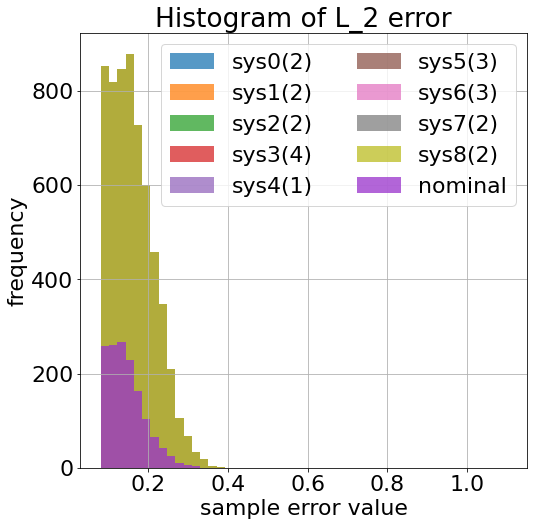

In [15]:
# visualization
for idx in range(num_system):
  print('L2 mean:',np.mean(err_L2_total[idx]),
        'L2 variance:',np.var(err_L2_total[idx]),
        'L_inf mean:',np.mean(err_Linf_total[idx]))
plt.rcParams.update({'font.size': 22})
fig3=plt.figure(figsize=(8,8))
bins=np.linspace(0.08,1.1,50)
for idx in range(num_system):
  plt.hist(err_L2_total[i],bins,alpha=0.75,label='sys%s(%d)'%(idx,del_num[idx]))
plt.hist(nominal,bins,alpha=0.75,label='nominal', color='darkorchid')
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
plt.grid(True)
plt.show()

In [16]:
# warm start
max_epochs=20
l2_total=[]
linf_total=[]
net_loss=[]
net_retrain=[]

for idx in range(num_system):
  # load model
  print('Perturbation ',idx)
  net_warm=myGCN([10,15,15,10,10]).to(device)
  path='./drive/My Drive/gnn/geometric/118ac_topoadapt.pickle'
  net_warm.load_state_dict(torch.load(path))
  net_warm.train()
  optimizer=torch.optim.Adam(net_warm.parameters())
  # data helper
  line_bus1=line_bus.copy()
  for i in range(num_line,0,-1):
    if del_idx[idx,i-1]>0:
      line_bus1=np.delete(line_bus1,i-1,0)
  w_pert=graph_laplacian(line_bus1,num_line-del_num[idx],num_bus) # v2v
  w_pert=np.abs(w_pert)
  data_pert=data_helper(w_pert.copy(),x_pert[idx].copy(),y_pert[idx].copy())
  pert_set=DataLoader(data_pert,batch_size=128,shuffle=True)
  # retrain
  loss_optm=[]
  for epoch in range(max_epochs):
    pert_loss=0.0
    for batch in pert_set:
      optimizer.zero_grad()
      batch=batch.to(device)
      logits=net_warm(batch)
      loss=my_loss_func(logits,batch.y.squeeze())
      loss.backward()
      pert_loss+=loss.item()
      optimizer.step()
    loss_optm.append(pert_loss/len(pert_set.dataset))
    if epoch%10==0: print("Epoch %d | Training loss: %.4f"%(epoch,loss_optm[-1]))
  # save retrained models
  net_pert.eval()
  net_retrain.append(net_pert)
  path='./drive/My Drive/gnn/geometric/'
  name='118ac_topoadapt_sys%d.pickle'%(idx)
  torch.save(net_pert.state_dict(),path+name)
  # calculate error
  y_pred=[]
  y_label=[]
  for batch in pert_set:
    batch=batch.to(device)
    logits=net(batch)
    y_pred.extend(logits.squeeze().cpu().detach().numpy())
    y_label.extend(batch.y.squeeze().cpu().detach().numpy())
  y_pred=np.array(y_pred)
  y_label=np.array(y_label)
  num_pert=len(pert_set.dataset)
  err_L2=np.zeros(num_pert)
  err_Linf=np.zeros(num_pert)
  for sample in range(0,len(y_label),num_bus):
    err_L2[sample//num_bus]=np.linalg.norm(y_label[sample:sample+num_bus]-y_pred[sample:sample+num_bus])/np.linalg.norm(y_label[sample:sample+num_bus])
    err_Linf[sample//num_bus]=np.max(np.abs(y_label[sample:sample+num_bus]-y_pred[sample:sample+num_bus]))/np.max(np.abs(y_label[sample:sample+num_bus]))
  l2_total.append(err_L2)
  linf_total.append(err_Linf)

Perturbation  0
Epoch 0 | Training loss: 22419904929.5794
Epoch 10 | Training loss: 22388679058.2648
Perturbation  1
Epoch 0 | Training loss: 0.0577
Epoch 10 | Training loss: 0.0320
Perturbation  2
Epoch 0 | Training loss: 0.0634
Epoch 10 | Training loss: 0.0388
Perturbation  3
Epoch 0 | Training loss: 0.0574
Epoch 10 | Training loss: 0.0305
Perturbation  4
Epoch 0 | Training loss: 0.0591
Epoch 10 | Training loss: 0.0336
Perturbation  5
Epoch 0 | Training loss: 14484844485.5113
Epoch 10 | Training loss: 14480399780.5525
Perturbation  6
Epoch 0 | Training loss: 0.0646
Epoch 10 | Training loss: 0.0388
Perturbation  7
Epoch 0 | Training loss: 0.0585
Epoch 10 | Training loss: 0.0331
Perturbation  8
Epoch 0 | Training loss: 0.0644
Epoch 10 | Training loss: 0.0404


Nominal System:
L2 mean: 0.13015710739472083 L2 variance: 0.0027700149267304037 L_inf mean: 0.23951544453984216
Perturbed systems retrained
Sys0 | L2 mean:0.148014 | L2 variance:0.005003 | LInf:0.233698
Sys1 | L2 mean:0.145649 | L2 variance:0.003253 | LInf:0.252585
Sys2 | L2 mean:0.145420 | L2 variance:0.003607 | LInf:0.226232
Sys3 | L2 mean:0.147691 | L2 variance:0.003439 | LInf:0.258254
Sys4 | L2 mean:0.143639 | L2 variance:0.003459 | LInf:0.235002
Sys5 | L2 mean:0.211476 | L2 variance:0.015808 | LInf:0.386796
Sys6 | L2 mean:0.146602 | L2 variance:0.003465 | LInf:0.227194
Sys7 | L2 mean:0.144073 | L2 variance:0.003440 | LInf:0.235606
Sys8 | L2 mean:0.148225 | L2 variance:0.003652 | LInf:0.228844


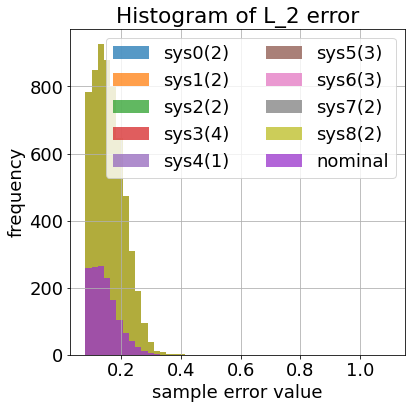

In [17]:
net.eval()
y_pred=[]
y_label=[]
for batch in trainset:
  batch=batch.to(device)
  logits=net(batch)
  y_pred.extend(logits.squeeze().cpu().detach().numpy())
  y_label.extend(batch.y.squeeze().cpu().detach().numpy())
y_pred=np.array(y_pred)
y_label=np.array(y_label)

num_train=len(train)
err_L2=np.zeros(num_train)
err_Linf=np.zeros(num_train)
for idx in range(0,len(y_label),num_bus):
  err_L2[idx//num_bus]=np.linalg.norm(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus])/np.linalg.norm(y_label[idx:idx+num_bus])
  err_Linf[idx//num_bus]=np.max(np.abs(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus]))/np.max(np.abs(y_label[idx:idx+num_bus]))
print('Nominal System:')
print('L2 mean:',np.mean(err_L2),
      'L2 variance:',np.var(err_L2),
      'L_inf mean:',np.mean(err_Linf))

print('Perturbed systems retrained')
for idx in range(num_system):
  l2_mean=np.mean(l2_total[idx])
  l2_var=np.var(l2_total[idx])
  linf_mean=np.mean(linf_total[idx])
  print('Sys%d | L2 mean:%f | L2 variance:%f | LInf:%f'%(idx,l2_mean,l2_var,linf_mean))
plt.rcParams.update({'font.size':18})
fig4=plt.figure(figsize=(6,6))
bins=np.linspace(0.08,1.1,50)
for idx in range(num_system):
  plt.hist(l2_total[i],bins,alpha=0.75,label='sys%s(%d)'%(idx,del_num[idx]))
plt.hist(nominal,bins,alpha=0.75,label='nominal', color='darkorchid')
plt.legend(loc='upper right',ncol=2)
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
plt.grid(True)
plt.show()